Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513/EEL410250 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$


# Exercício 5: SVM

Neste exercício você irá construir classificadores usando máquinas de vetores de suporte (SVM), tando em sua versão linear quanto na versão baseada em kernels. Também serão abordadas técnicas de validação cruzada para avaliação de desempenho e busca de hiperparâmetros.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import wget
from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

def plot_data(X, y, colors=['bo','rx','gs','md','c^','yP']):
    ''' Plot 1-D or 2-D classification dataset '''
    assert len(X.shape) == 2 and len(y.shape) == 1
    classes = np.unique(y)
    assert len(classes) <= len(colors)
    dim = X.shape[1]
    assert 0 < dim <= 2
    if dim == 1:
        for i in range(len(classes)):
            plt.plot(X[y==classes[i],0],np.zeros(np.sum(y==classes[i])),colors[i])
        plt.gca().axes.get_yaxis().set_ticks([])
    else:
        for i in range(len(classes)):
            plt.plot(X[y==classes[i],0],X[y==classes[i],1],colors[i])
    return

def plot_svm(model, X, heatmap=False, circles=None, N=100, gap=1e-9):
    ''' Plot decision regions for a 1-D or 2-D binary SVM classifier '''
    assert len(X.shape) == 2
    dim = X.shape[1]
    assert 0 < dim <= 2
    x1_min, x1_max = X[:,0].min()-gap, X[:,0].max()+gap
    if dim == 1:
        x2_min, x2_max = -1, 1
        N2 = 2
    else:
        x2_min, x2_max = X[:,1].min()-gap, X[:,1].max()+gap
        N2 = N
    xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max,N), np.linspace(x2_min,x2_max,N2))
    if dim == 1:
        XX = np.c_[xx1.reshape(-1)]
    else:
        XX = np.c_[xx1.reshape(-1), xx2.reshape(-1)]
    z = model.decision_function(XX)
    assert len(z.shape) == 1
    z = z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,np.sign(z),cmap=plt.cm.bwr,vmin=-3,vmax=3)
    plt.contour(xx1,xx2,z,cmap=plt.cm.gray,vmin=np.inf,vmax=np.inf,levels=[0])
    if heatmap:
        a = np.max(np.abs(z))*2
        plt.contourf(xx1,xx2,z,100,cmap=plt.cm.bwr,vmin=-a,vmax=a)
        if circles == None:
            circles = False
    else:
        plt.contourf(xx1,xx2,z,cmap=plt.cm.bwr,vmin=-3,vmax=3,levels=[-1,0,1])
        if circles == None:
            circles = True
    if circles:
        S = X[model.support_]
        if dim == 1:
            S = np.c_[S, np.zeros(S.shape[0])]
        plt.plot(*S.T,'go',mfc='none',ms=12)
    return

# 1. Conjunto de dados #1

O primeiro conjunto de dados pode ser carregado pelo comando abaixo. Para simplificar, não usaremos conjunto de teste.

100% [..................................................................................] 981 / 981

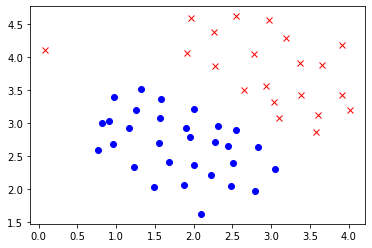

In [2]:
if not os.path.exists('svm1.mat'):
    wget.download('https://github.com/danilo-silva-ufsc/ml/raw/master/data/svm1.mat')
data = loadmat('svm1.mat')
X, y = data['X'], data['y'].reshape(-1)
plot_data(X, y)

Train accuracy: 98.0%


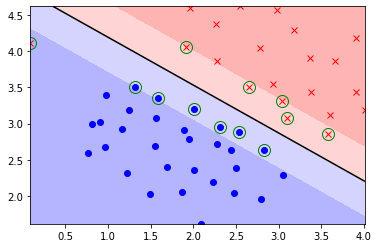

In [3]:
model = SVC(C=1, kernel='linear')
model.fit(X, y)
print('Train accuracy: {:.1%}'.format(model.score(X, y)))
plot_data(X, y)
plot_svm(model,X)

## SVM linear

Os círculos no gráfico acima marcam os **vetores de suporte**. Note que, no classificador SVM, o classificador é definido exclusivamente a partir dos vetores de suporte, i.e., as demais amostras de treinamento que satisfazem a margem não tem impacto no classificador.

1. Determine os vetores de suporte, os índices dos vetores de suporte, e o vetor de coeficientes da solução dual ($\alpha_i y_s^{(i)}$).
1. A partir deles, determine o vetor de pesos (da solução primal) $\bw$, bem como o termo de *bias* $b$. Confirme que os valores são os mesmos fornecidos pelo modelo (o termo $b$ até a segunda casa decimal).

#### Dicas
- Reveja as equações nos slides da disciplina.
- Leia a documentação do SVC do sklearn em:
 - https://scikit-learn.org/stable/modules/svm.html#svc
 - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

### Variando $C$

3. Varie o valor de $C$ até obter 100% de acurácia.
1. Analise os resultados observados:
 1. O que acontece com a fronteira de decisão? Por quê? 
 1. Que interpretação pode ser dada para o parâmetro $C$? 
 1. O ajuste obtido parece ser adequado? Explique.

### Escala dos atributos

5. Para um modelo com $C=1$, reescale os atributos conforme a célula abaixo e verifique o impacto no modelo treinado. Como você explica as diferenças?
1. A partir dos resultados observados, que recomendação você daria para o treinamento de um classificador SVM?

Ao final desta parte, **retorne os dados para a escala original**.

In [4]:
# Try each of them
#d = [0.1,10]
d = [1,1]
#d = [10,0.1]
X = data['X'] @ np.diag(d)

## SVM com kernel RBF (gaussiano)

Nesta parte você utilizará um kernel RBF para obter uma fronteira de decisão não-linear.

Em geral, um kernel pode ser interpretado como uma função que mede a **similaridade** entre um par de amostras ($x^{(i)}$, $x^{(j)}$). No caso do kernel RBF, a similaridade é definida como uma função da distância euclidiana entre as amostras, mais precisamente:

$$ K_{\text{RBF}} \left( x^{(i)}, x^{(j)} \right) = \exp \left( - \gamma \| x^{(i)} - x^{(j)}\|^2 \right) $$

O parâmetro $\gamma$ (um **hiperparâmetro** do modelo) determina quão rápido a similaridade decai com a distância.

Em contraste, o kernel linear não possui hiperparâmetros, sendo definido simplesmente como o produto interno entre amostras:

$$ K_{\text{linear}} \left( x^{(i)}, x^{(j)} \right) = {x^{(i)}}^T x^{(j)} $$

O uso do kernel linear resulta no classificador linear visto anteriormente.

Em qualquer caso, a função de decisão (score de confiança) é dada por
$$
z = \bw^T \bx + b =b + \sum_{i \in \calS} \alpha_i y_s^{(i)} K(\bx^{(i)},\bx)
$$
onde $\calS$ denota o conjunto de índices dos vetores de suporte. Portanto, a predição é realizada calculando o kernel somente com relação aos vetores de suporte, i.e., apenas a similaridade com relação aos vetores de suporte é relevante.

### Usando o kernel da biblioteca

7. Refaça a classificação utilizando o kernel `rbf` fornecido na própria função `SVC`, definindo e variando o parâmetro `gamma`.
1. O que você observa? Qual o efeito do parâmetro $\gamma$? Note que esse efeito pode ser melhor visualizado utilizando um valor muito alto para `C` (por exemplo, `C = 1e6`), o que corresponde a um problema praticamente sem regularização.

Caso deseje, você pode utilizar a opção `heatmap` (possivelmente com `circles=True`) na função `plot_svm` para ajudar na visualização. Nesse caso as regiões mais vermelhas representam um valor de $z$ (discriminante ou função de decisão) mais positivo, enquanto as regiões mais azuis representam um valor de $z$ mais negativo (mas a margem deixa de ser mostrada).

### Implementando seu próprio kernel

9. Em seguida, implemente o seu próprio kernel RBF usando a função `my_kernel` definida abaixo. Como exemplo, está implementado um kernel linear. 

O kernel customizado pode ser usado na função SVC através do comando:

```python
model = SVC(C=1, kernel=my_kernel)
```

Nesse caso, o parâmetro `gamma` deve ser definido como variável global (externa à função), para que você possa variá-lo, uma vez que a biblioteca sklearn não permite passar argumentos adicionais para a função de kernel customizado (em particular, o parâmetro `gamma` do `SVC` é ignorado para qualquer kernel customizado).

Alternativamente, você pode definir a função de kernel usando uma função anônima:

```python
model = SVC(C=1, kernel=lambda X1, X2: my_kernel(X1,X2,gamma))
```

e definir `gamma` como um argumento adicional de `my_kernel`.

In [5]:
def my_kernel(X1, X2):
    '''
    Computes custom kernel.
    
    Parameters
    ----------
    X1 : array of shape (m1, n_features)
    X2 : array of shape (m2, n_features)
    
    Returns
    -------
    kernel_matrix : array of shape (m1, m2)
    
    '''
    
    kernel_matrix = X1 @ X2.T
    
    return kernel_matrix

Certifique-se que sua implementação está correta rodando o código abaixo.

In [6]:
from sklearn.metrics.pairwise import rbf_kernel
X1 = np.random.randn(2,4)
X2 = np.random.randn(3,4)
gamma = 1/8
sim = my_kernel(X1, X2)
sim2 = rbf_kernel(X1, X2, gamma=gamma)
if abs(sim - sim2).sum() < 1e-10: print('OK')

OK


10. Em seguida, realize novamente a classificação para obter o mesmo resultado anterior.

Após garantir que você conseguiu implementar corretamente um kernel RBF, **você pode voltar a usar o kernel da própria função SVC** (o qual tem provavelmente uma implementação mais eficiente).

# 2. Conjuntos de dados #2

O próximo conjunto de dados pode ser carregado pelo comando abaixo. (Suponha novamente que todo esse conjunto esteja disponível para desenvolvimento.)

100% [................................................................................] 7604 / 7604

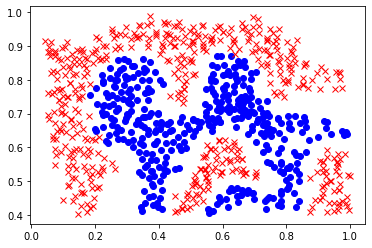

In [7]:
if not os.path.exists('svm2.mat'):
    wget.download('https://github.com/danilo-silva-ufsc/ml/raw/master/data/svm2.mat')
data = loadmat('svm2.mat')
X, y = data['X'], data['y'].reshape(-1)
plot_data(X, y)

## Variando hiperparâmetros

1. Utilize novamente um kernel RBF. Varie os hiperparâmetros $C$ e $\gamma$ e observe seus efeitos. Tente encontrar valores que forneçam uma explicação aparentemente mais "natural" possível para os dados.
1. Explique o seu raciocínio.

## Experimentando outros kernels

3. Tente conseguir o mesmo resultado usando um kernel polinomial (semelhante a uma adição de atributos polinomiais). Para isto, utilize `kernel='poly'`, defina os parâmetros `degree=d`, `gamma='auto'`, `coef0=1` e varie $C$ e $d$. (Se desejar, varie `gamma`e `coef0` também, mas evite aumentar muito ou esteja preparado para eventualmente ter que reiniciar o interpretador.)
1. Que grau $d$ foi necessário? Como você compara as duas soluções, levando em conta também o ponto de vista prático?
1. (OPCIONAL) Experimente também `kernel=sigmoid`.

## Avaliação de desempenho via validação cruzada $k$-fold

Suponha (como neste exemplo) que você não separou um conjunto de validação. Como saber se seu modelo está sofrendo de overfitting? Como obter uma estimativa de desempenho mais realista do que a acurácia de treinamento?

Uma possível abordagem é usando validação cruzada $k$-fold: particionar os dados em $k$ partes, e realizar $k$ treinamentos e testes, sempre testando em uma das partes um modelo treinado com as partes restantes. A estimativa de desempenho é a média de todos os testes.

Para isso você pode utilizar a função `sklearn.model_selection.cross_val_score()`.

6. Retorne ao kernel RBF e utilize os hiperparâmetros que você propôs anteriormente.
1. Realize uma validação cruzada 5-fold e mostre os resultados obtidos. Calcule também a acurácia média entre as 5 realizações. (Note que não é necessário treinar o modelo antes de aplicar a validação cruzada, pois o treinamento está implícito no método.)
1. Comente sobre os resultados observados.

**Obs:** Naturalmente, para uma estimativa de desempenho ainda mais realista, seria necessário avaliar o modelo em um conjunto independente de teste. (OPCIONAL) Por quê?

# 3. Conjunto de dados #3

O próximo conjunto de dados pode ser carregado pelo comando abaixo. Note que este é o mesmo conjunto utilizado no Exercício 4, exceto que o conjunto de validação agora tem o mesmo tamanho do conjunto de treinamento. (Para fins didáticos, o conjunto de teste continua extremamente grande.)

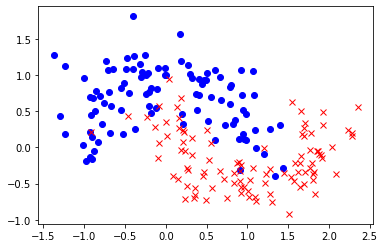

In [8]:
from sklearn.datasets import make_moons
np.random.seed(2019*2)
X, y = make_moons(n_samples=200, noise=0.25)
X_val, y_val = make_moons(n_samples=200, noise=0.25)
X_test, y_test = make_moons(n_samples=10000, noise=0.25)
plot_data(X, y)

## Busca de hiperparâmetros: Grid search (com implementação própria)

Aqui continuaremos utilizando um classificador SVM com kernel RBF. Sua tarefa é determinar os melhores valores dos hiperparâmetros de acordo com o desempenho no conjunto de validação. Em outras palavras, você deve variar $C$ e $\gamma$, sempre treinando o modelo no conjunto de treinamento e medindo o desempenho no conjunto de validação, até encontrar os valores que maximizam a acurácia de validação.

Para isso, você pode definir os conjuntos `range_C` e `range_gamma` e variar $(C,\gamma)$ dentro da grade `range_C` x `range_gamma` (este método é conhecido como [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search)), o que pode ser implementado com dois laços `for`. Para ambos $C$ e $\gamma$, é recomendável utilizar valores que seguem uma progressão geométrica, i.e., regularmente espaçados no expoente.

1. Implemente seu método completando a função abaixo.
1. Em seguida, para os valores encontrados, trace o gráfico da região de decisão (com o conjunto de treinamento) e determine a acurácia nos conjuntos de treinamento, validação e teste.

#### Funções úteis

```python
np.logspace()
```

In [9]:
def search_svm(X, y, X_val, y_val):
    '''
    Finds C and gamma that maximize accuracy on the validation set.

    Parameters
    ----------
    X     : array of shape (m x n) consisting of m training examples.
    y     : array of shape (m, ) consisting of labels for the training data.
    X_val : array of shape (m_val x n) consisting of m_val validation examples.
    y_val : array of shape (m_val, ) consisting of labels for the validation data.
    
    Returns
    -------
    C     : float
    gamma : float
    '''
    
    return C, gamma

## Busca de hiperparâmetros: Grid search + Validação cruzada (via sklearn)

Suponha que você não possui ou não deseja separar um conjunto de validação (*hold-out*) como feito acima. Isto é, assuma que `X_val` e `y_val` não existem. Ainda assim é possível obter uma boa estimativa de desempenho---sem usar o conjunto de teste---e utilizá-la para a escolha de hiperparâmetros, utilizando validação cruzada $k$-fold.

Uma forma de implementar esta técnica seria eliminar os argumentos `X_val` e `y_val` da função `search_svm` e alterá-la de forma a utilizar `cross_val_score()`. Para facilitar, vamos diretamente utilizar a biblioteca `sklearn`, a qual já possui uma implementação eficiente da *grid search* com validação cruzada, mais precisamente a função `sklearn.model_selection.GridSearchCV()`.

3. Realize uma busca de hiperparâmetros através de *grid search* com validação cruzada 5-fold.
1. Para o melhor classificador encontrado, trace o gráfico da região de decisão (com o conjunto de treinamento) e determine a acurácia nos conjuntos de treinamento e teste (lembre que não existe mais conjunto de validação separado).
1. Comente sobre os resultados observados.

#### Dicas

- Para utilizar a função `GridSearchCV` você precisará definir o argumento `param_grid`. Por exemplo:

```
param_grid = {'C':[1,10,100], 'gamma':[0.1,1,10]}
```

- Estude a documentação da função `GridSearchCV`. Em particular, as propriedades `.best_estimator_` e `.cv_results_` são interessantes e possivelmente úteis.

In [10]:
del X_val, y_val # just in case

# 4. Conjunto de dados #4

O último conjunto de dados consiste de mensagens sobre tópicos diferentes e a tarefa consiste em identificar o tópico correspondente a cada mensagem. O conjunto completo possui 20 categorias; para uma classificação binária, utilizaremos apenas duas. Mais informações sobre o conjunto de dados podem ser encontradas em:

https://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset

O conjunto de dados pode ser carregado pelos comandos abaixo.

In [11]:
from sklearn.datasets import fetch_20newsgroups
categories = ['sci.med','soc.religion.christian']
remove = ['headers','footers','quotes']
data_train = fetch_20newsgroups(subset='train',categories=categories, remove=remove)
data_test = fetch_20newsgroups(subset='test',categories=categories, remove=remove)
categories = data_train['target_names'] # just in case it gets reversed
msg = data_train['data']
y = data_train['target']
msg_test = data_test['data']
y_test = data_test['target']

In [12]:
# A few samples
for i in [9,8]:
    print('\ny = %d (%s)\n-----' % (y[i],categories[y[i]]))
    print(msg[i],'\n')


y = 0 (sci.med)
-----
I am currently doing a group research project on the drug Xanax.  I would
be exponentially gracious to receive any and all information you could
provide
me regarding its usage, history, mechanism of reaction, side effects, and
other pertinent information.  I don't care how long or how short your 
response is. 


y = 1 (soc.religion.christian)
-----

I have no doubt that God hears everybody's prayers.
However, He does things His way, i.e. things will happen
only if it is His will.

Now if the question really is "Does God grant everybody's wishes ?"
then you'll get a brutal shot of reality similar to when you didn't
get that toy you wanted for Christmas. You just cannot expect
to get everything you want in this world.

--  



## Pré-processamento dos dados

Para converter texto em vetores numéricos, utilizaremos o modelo _bag-of-words_ (BoW). Leia a seção 4.6-4.6.1 do livro do Watt para se familiar com este conceito.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
prep = make_pipeline(CountVectorizer())
X = prep.fit_transform(msg)
X_test = prep.transform(msg_test)
voc = prep.steps[0][1].vocabulary_
inv_voc = {i: v for v, i in voc.items()}

print(voc['research'])
print(inv_voc[15704])
print(X[9].sorted_indices())

15704
research
  (0, 1670)	1
  (0, 1750)	1
  (0, 1837)	2
  (0, 1970)	1
  (0, 2680)	1
  (0, 3566)	1
  (0, 4933)	1
  (0, 5199)	1
  (0, 6202)	1
  (0, 6221)	1
  (0, 6344)	1
  (0, 6552)	1
  (0, 7284)	1
  (0, 8443)	1
  (0, 8559)	1
  (0, 9056)	1
  (0, 9204)	2
  (0, 9773)	2
  (0, 10175)	1
  (0, 10230)	1
  (0, 11238)	1
  (0, 11708)	1
  (0, 11743)	1
  (0, 13074)	1
  (0, 13147)	1
  (0, 13233)	1
  (0, 13330)	1
  (0, 13891)	1
  (0, 14706)	1
  (0, 14820)	1
  (0, 15204)	1
  (0, 15273)	1
  (0, 15434)	1
  (0, 15704)	1
  (0, 15775)	1
  (0, 16830)	1
  (0, 16876)	1
  (0, 18423)	1
  (0, 18658)	1
  (0, 19478)	1
  (0, 20317)	1
  (0, 20376)	1
  (0, 20456)	1
  (0, 20463)	1


## Classificação com SVM linear

Para este exercício você usará apenas um SVM linear. Nesse caso, **não utilize a função `SVC` do sklearn**. Ao invés disso, utilize a função `LinearSVC`, a qual possui uma implementação otimizada para SVM linear.

1. Treine um SVM linear e encontre os melhores hiperparâmetros (no caso, apenas $C$).
1. Para o modelo treinado, calcule a acurácia no conjunto de treinamento via validação cruzada 5-fold, e calcule também a acurácia de teste (hold-out).

## Aprimorando o modelo

Você conseguiu pelo menos 94% de acurácia na validação cruzada?

3. Em caso negativo, tente aprimorar o modelo. Considere, por exemplo, o escalonamento dos atributos. Faz sentido, por exemplo, usar um `StandardScaler`, considerando que $X$ é uma matriz esparsa? Ou faria mais sentido normalizar os atributos internamente a cada amostra? Isto pode ser feito por qualquer das funções abaixo:
```python
sklearn.preprocessing.Normalizer
sklearn.feature_extraction.text.TfidfTransformer(use_idf=False)
```
1. Explique o seu raciocínio e os resultados observados.
1. Estude a documentação dos transformadores `CountVectorizer` e `TfidfTransformer` e veja se consegue atingir o desempenho desejado.

## Realizando predições

6. Determine a predição fornecida pelo seu modelo para os seguintes exemplos (retirados da Wikipedia):

```
A vaccine is a biological preparation that provides active acquired immunity to a particular disease.
```

```
Baptism is the ritual act, with the use of water, by which a person is admitted to membership of the Church. Beliefs on baptism vary among denominations.
```

## Preditores mais importantes

Como o modelo é um classificador linear, podemos determinar quais atributos são mais relevantes para a classificação analisando o vetor de pesos $\bw$.

7. Determine os 5 vocábulos mais preditivos de cada classe (i.e., 10 no total).
1. Quantos atributos são considerados (pelo modelo) absolutamente irrelevantes para a classificação?

# (OPCIONAL)

- Aplique um classificador SVM em outros conjuntos de dados, como por exemplo:
 - https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset
 - https://scikit-learn.org/stable/datasets/index.html#olivetti-faces-dataset
 - https://archive.ics.uci.edu/ml/datasets/spambase